# Pizza Sales Analysis Project
This notebook aims to analyze pizza sales data and build regression models to predict total sales.

## Import libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor      
from sklearn.svm import SVR
from xgboost import XGBRegressor 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

## Data Loading and Initial Exploration
I load a dataset, check data information, make changes to columns, check for missing values ​​and duplicates.

In [5]:
df = pd.read_excel('./main_pizza_dataset_ansh.xlsx')

In [7]:
df.head()

,order_date,time_phase,quantity,total_price,Date,Month_name,Day_name,Weekend
0,2015-01-01,Morning,6,105.25,1,January,Thursday,0
1,2015-01-01,Afternoon,106,1757.35,1,January,Thursday,0
2,2015-01-01,Night,50,851.25,1,January,Thursday,0
3,2015-01-02,Night,82,1358.95,2,January,Friday,0
4,2015-01-02,Morning,5,87.25,2,January,Friday,0


In [8]:
df = df.drop(columns='order_date')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time_phase   1048 non-null   object 
 1   quantity     1048 non-null   int64  
 2   total_price  1048 non-null   float64
 3   Date         1048 non-null   int64  
 4   Month_name   1048 non-null   object 
 5   Day_name     1048 non-null   object 
 6   Weekend      1048 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 57.4+ KB


In [10]:
df.head()

,time_phase,quantity,total_price,Date,Month_name,Day_name,Weekend
0,Morning,6,105.25,1,January,Thursday,0
1,Afternoon,106,1757.35,1,January,Thursday,0
2,Night,50,851.25,1,January,Thursday,0
3,Night,82,1358.95,2,January,Friday,0
4,Morning,5,87.25,2,January,Friday,0


In [11]:
columns = df.columns.to_list()

In [12]:
columns

['time_phase',
 'quantity',
 'total_price',
 'Date',
 'Month_name',
 'Day_name',
 'Weekend']

In [13]:
columns[3] = 'Day_of_month'

In [14]:
df.columns = columns

In [15]:
df

,time_phase,quantity,total_price,Day_of_month,Month_name,Day_name,Weekend
0,Morning,6,105.25,1,January,Thursday,0
1,Afternoon,106,1757.35,1,January,Thursday,0
2,Night,50,851.25,1,January,Thursday,0
3,Night,82,1358.95,2,January,Friday,0
4,Morning,5,87.25,2,January,Friday,0
...,...,...,...,...,...,...,...
1043,Night,16,276.25,30,December,Wednesday,0
1044,Afternoon,45,736.15,30,December,Wednesday,0
1045,Morning,5,77.75,31,December,Thursday,0
1046,Afternoon,97,1566.95,31,December,Thursday,0


In [16]:
df.describe()[['quantity','total_price']]

,quantity,total_price
count,1048.000000,1048.000000
mean,47.303435,780.400811
std,33.035038,546.061892
min,1.000000,10.500000
25%,12.000000,196.350000
50%,45.000000,763.050000
75%,76.000000,1245.712500
max,163.000000,2685.450000


In [17]:
df.isna().sum()

time_phase      0
quantity        0
total_price     0
Day_of_month    0
Month_name      0
Day_name        0
Weekend         0
dtype: int64

In [18]:
df.duplicated().sum()

0

## Data visualizations
I visualize sales trends and seasonality.

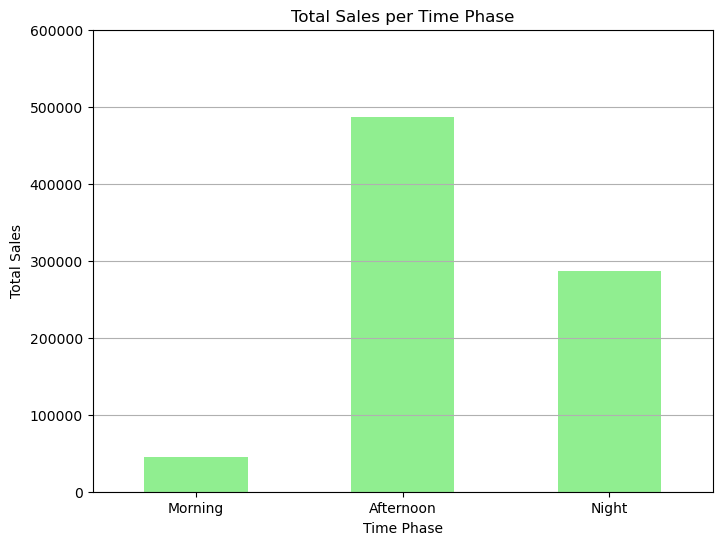

In [19]:
time_phase_sales = df.groupby('time_phase')['total_price'].sum()


ordered_phases = ['Morning', 'Afternoon', 'Night']
time_phase_sales = time_phase_sales.reindex(ordered_phases)


plt.figure(figsize=(8, 6))
time_phase_sales.plot(kind='bar', color='lightgreen')
plt.title('Total Sales per Time Phase')
plt.xlabel('Time Phase')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.ylim(top=600000)
plt.show()

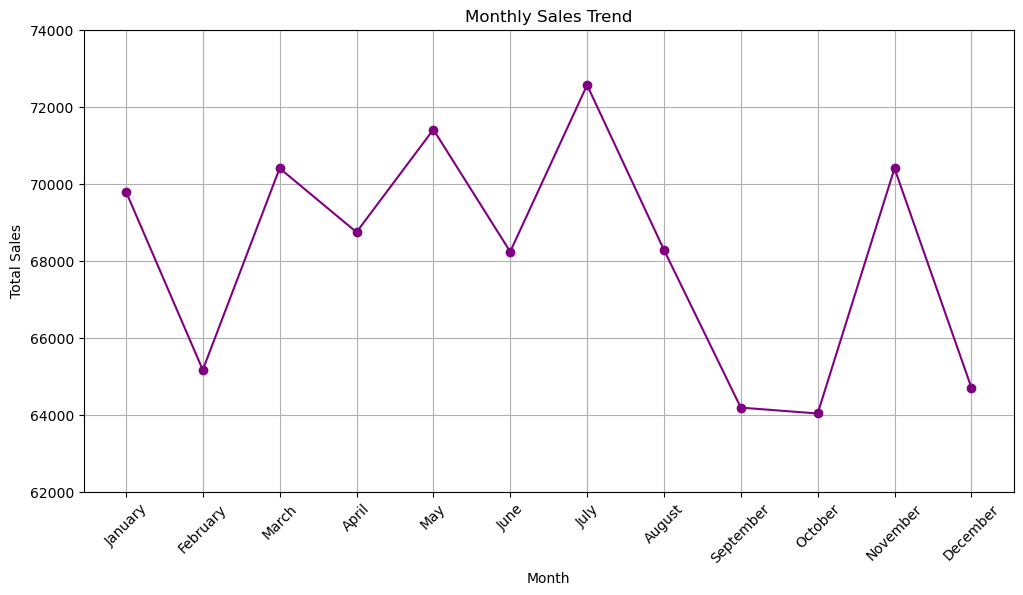

In [20]:
monthly_sales = df.groupby('Month_name')['total_price'].sum()
monthly_sales = monthly_sales.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', color='purple', linestyle='-')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.ylim(bottom=62000) 
plt.ylim(top=74000)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


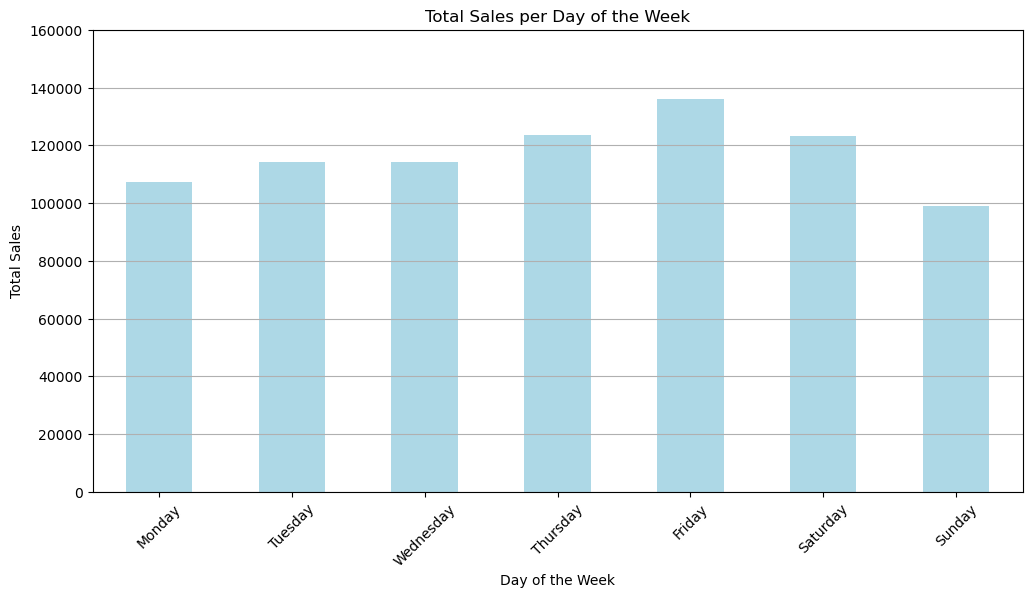

In [21]:
weekly_sales = df.groupby('Day_name')['total_price'].sum()


ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.reindex(ordered_days)


plt.figure(figsize=(12, 6))
weekly_sales.plot(kind='bar', color='lightblue')
plt.title('Total Sales per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(top=160000)
plt.show()


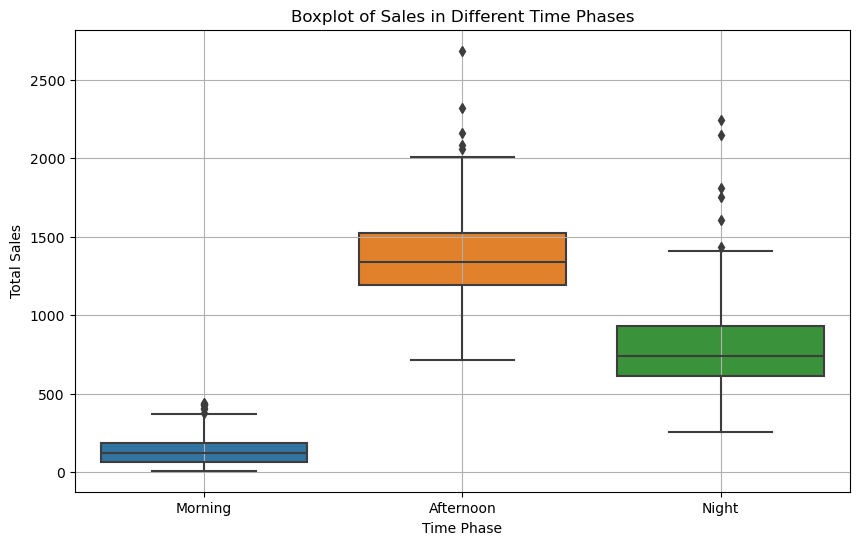

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='time_phase', y='total_price', data=df, order=['Morning', 'Afternoon', 'Night'])
plt.title('Boxplot of Sales in Different Time Phases')
plt.xlabel('Time Phase')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


## Feature coding
I encode categorical features, examine correlations between features and create histograms.

In [23]:
df1 = df[['time_phase', 'Month_name', 'Day_name']]

In [24]:
df1

,time_phase,Month_name,Day_name
0,Morning,January,Thursday
1,Afternoon,January,Thursday
2,Night,January,Thursday
3,Night,January,Friday
4,Morning,January,Friday
...,...,...,...
1043,Night,December,Wednesday
1044,Afternoon,December,Wednesday
1045,Morning,December,Thursday
1046,Afternoon,December,Thursday


In [25]:
df2 = df.drop(columns=df1)

In [26]:
df_encoded = pd.get_dummies(df1).astype('int')

In [27]:
df_encoded

,time_phase_Afternoon,time_phase_Morning,time_phase_Night,Month_name_April,Month_name_August,Month_name_December,Month_name_February,Month_name_January,Month_name_July,Month_name_June,...,Month_name_November,Month_name_October,Month_name_September,Day_name_Friday,Day_name_Monday,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1044,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1045,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1046,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
df = pd.merge(df2, df_encoded, left_index=True, right_index=True)

In [29]:
df.corr()

,quantity,total_price,Day_of_month,Weekend,time_phase_Afternoon,time_phase_Morning,time_phase_Night,Month_name_April,Month_name_August,Month_name_December,...,Month_name_November,Month_name_October,Month_name_September,Day_name_Friday,Day_name_Monday,Day_name_Saturday,Day_name_Sunday,Day_name_Thursday,Day_name_Tuesday,Day_name_Wednesday
quantity,1.000000,0.998820,-0.021350,-0.012273,0.763720,-0.804703,0.025676,-0.006117,-0.014020,-0.028508,...,0.015774,0.021286,-0.003872,0.094606,-0.027423,0.057189,-0.072715,0.015775,-0.039322,-0.027647
total_price,0.998820,1.000000,-0.020748,-0.015359,0.763251,-0.803319,0.024787,-0.004508,-0.017000,-0.029817,...,0.015844,0.021024,-0.003840,0.094918,-0.025635,0.054867,-0.074394,0.016526,-0.037371,-0.028508
Day_of_month,-0.021350,-0.020748,1.000000,0.005964,0.004386,-0.008942,0.004386,-0.006966,0.022683,0.007427,...,-0.009322,0.005632,-0.023828,-0.009032,0.012724,0.023433,-0.015592,-0.007518,0.003736,-0.007212
Weekend,-0.012273,-0.015359,0.005964,1.000000,0.022195,-0.045251,0.022195,-0.012455,0.021350,-0.012455,...,0.007155,0.019633,0.000256,-0.252797,-0.246866,0.645257,0.650442,-0.256718,-0.258669,-0.256718
time_phase_Afternoon,0.763720,0.763251,0.004386,0.022195,1.000000,-0.490489,-0.518841,-0.002906,-0.000614,-0.002906,...,0.002046,0.002721,-0.002630,-0.007127,-0.006960,0.016417,0.012353,-0.003449,-0.007292,-0.003449
time_phase_Morning,-0.804703,-0.803319,-0.008942,-0.045251,-0.490489,1.000000,-0.490489,0.005925,0.001251,0.005925,...,-0.004171,-0.005548,0.005363,0.014530,0.014189,-0.033472,-0.025185,0.007031,0.014867,0.007031
time_phase_Night,0.025676,0.024787,0.004386,0.022195,-0.518841,-0.490489,1.000000,-0.002906,-0.000614,-0.002906,...,0.002046,0.002721,-0.002630,-0.007127,-0.006960,0.016417,0.012353,-0.003449,-0.007292,-0.003449
Month_name_April,-0.006117,-0.004508,-0.006966,-0.012455,-0.002906,0.005925,-0.002906,1.000000,-0.093940,-0.092805,...,-0.091661,-0.086387,-0.089343,-0.007219,-0.002277,-0.012219,-0.003943,0.018579,-0.012002,0.018579
Month_name_August,-0.014020,-0.017000,0.022683,0.021350,-0.000614,0.001251,-0.000614,-0.093940,1.000000,-0.093940,...,-0.092782,-0.087443,-0.090436,-0.009916,0.024569,0.014727,0.012942,-0.013133,-0.014716,-0.013133
Month_name_December,-0.028508,-0.029817,0.007427,-0.012455,-0.002906,0.005925,-0.002906,-0.092805,-0.093940,1.000000,...,-0.091661,-0.086387,-0.089343,-0.036541,-0.002277,-0.002277,-0.013828,0.018579,0.016847,0.018579


In [30]:
X = df.drop(columns=['total_price','quantity'])
y = df['total_price']

array([[<Axes: title={'center': 'Day_of_month'}>,
        <Axes: title={'center': 'Weekend'}>,
        <Axes: title={'center': 'time_phase_Afternoon'}>,
        <Axes: title={'center': 'time_phase_Morning'}>,
        <Axes: title={'center': 'time_phase_Night'}>],
       [<Axes: title={'center': 'Month_name_April'}>,
        <Axes: title={'center': 'Month_name_August'}>,
        <Axes: title={'center': 'Month_name_December'}>,
        <Axes: title={'center': 'Month_name_February'}>,
        <Axes: title={'center': 'Month_name_January'}>],
       [<Axes: title={'center': 'Month_name_July'}>,
        <Axes: title={'center': 'Month_name_June'}>,
        <Axes: title={'center': 'Month_name_March'}>,
        <Axes: title={'center': 'Month_name_May'}>,
        <Axes: title={'center': 'Month_name_November'}>],
       [<Axes: title={'center': 'Month_name_October'}>,
        <Axes: title={'center': 'Month_name_September'}>,
        <Axes: title={'center': 'Day_name_Friday'}>,
        <Axes: titl

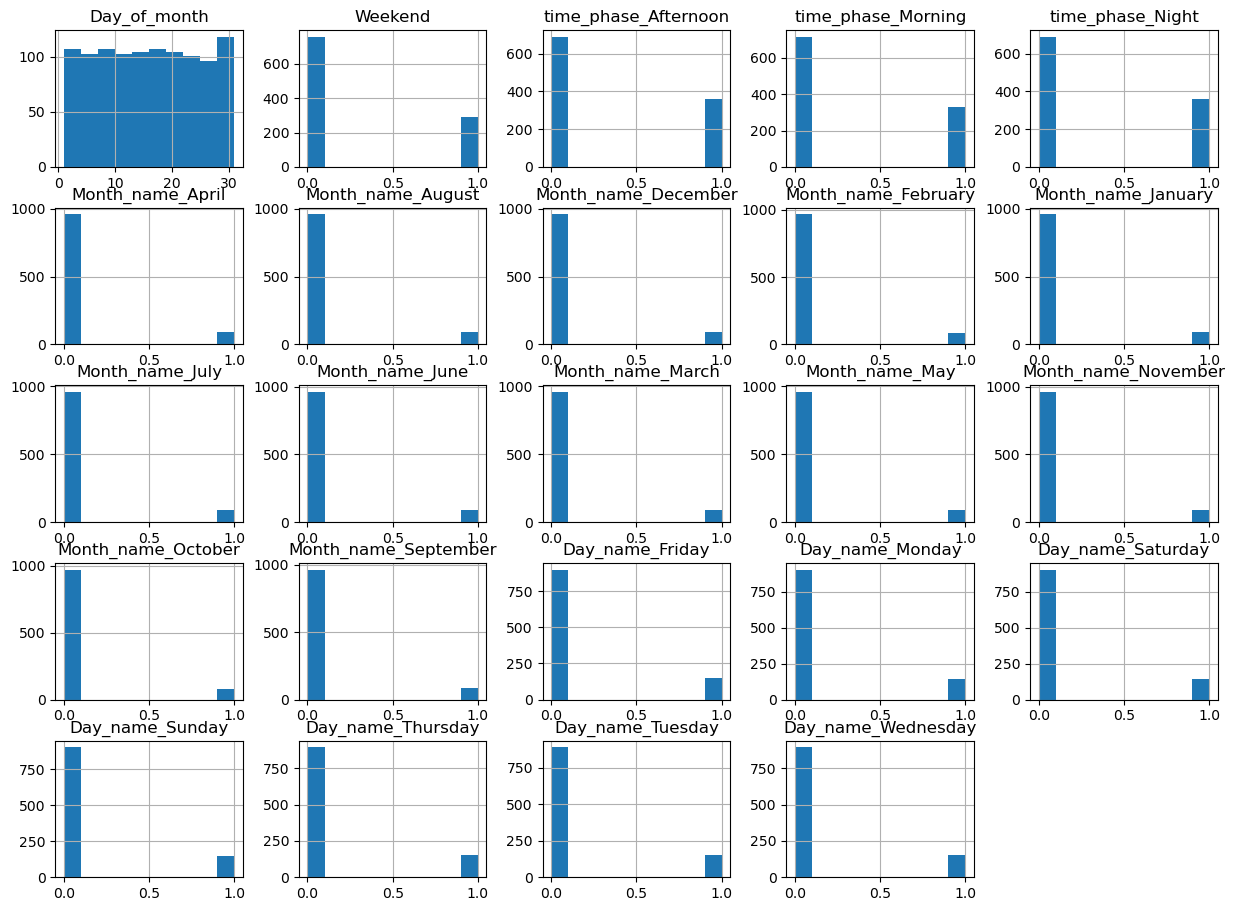

In [31]:
X.hist(figsize=(15, 11))


## Model training and evaluation
I divide the dataset into a training and test set and compare metrics for different regression models

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
models = {
    "Linear Regression" : LinearRegression(),
    "Decision Tree Regressor" : DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet(),
    "XGBoost Regressor": XGBRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    

    y_pred = [max(0, pred) for pred in y_pred]
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, mse, r2])



results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "R^2"])
results_df.set_index('Model').sort_values(by='MSE')

    


,MAE,MSE,R^2
Model,,,
Gradient Boosting,132.567477,35964.605957,0.872053
Lasso Regression,153.076496,44287.595406,0.842443
Ridge Regression,154.166491,44807.743215,0.840592
Linear Regression,154.356389,44831.849300,0.840507
Random Forest,151.340088,49757.129854,0.822984
XGBoost Regressor,177.428377,61831.885720,0.780027
Decision Tree Regressor,193.000476,78487.425190,0.720774
Elastic Net,311.157965,132176.522211,0.529770
Support Vector Regressor,462.557827,283057.605494,-0.007004


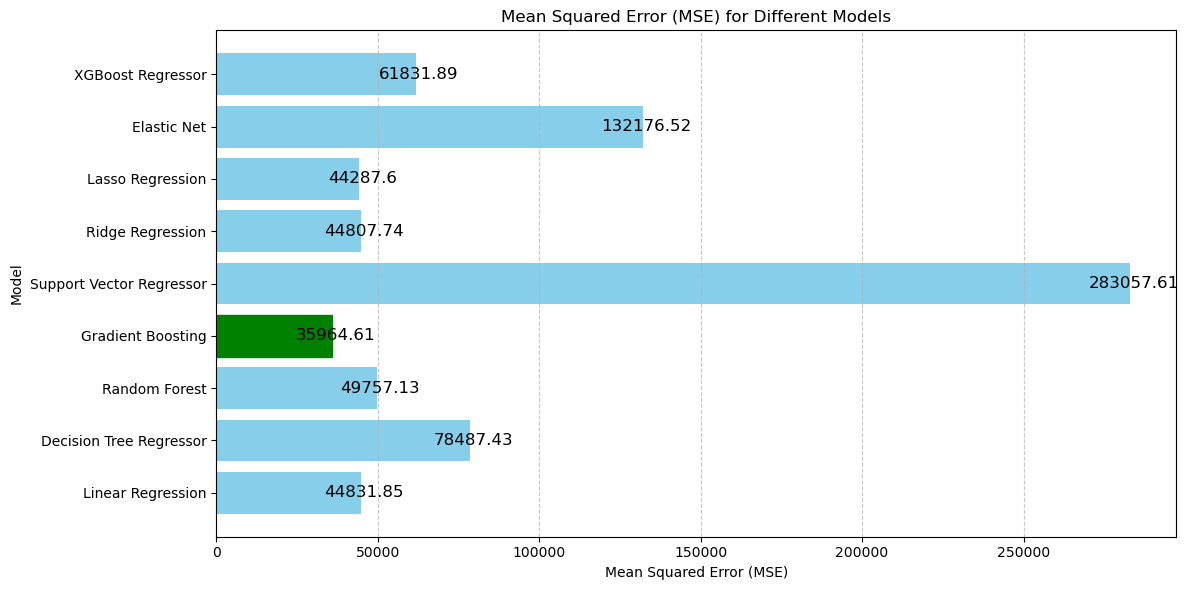

In [34]:
plt.figure(figsize=(12, 6))
bars = plt.barh(results_df["Model"], results_df["MSE"], color='skyblue')
best_model_index = results_df["MSE"].idxmin()
bars[best_model_index].set_color('green') 


for bar in bars:
    width = bar.get_width()
    plt.text(width + 1000, bar.get_y() + bar.get_height() / 2, round(width, 2), 
             ha='center', va='center', fontsize=12)


plt.title('Mean Squared Error (MSE) for Different Models')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Model')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Customizing hyperparameters
I select the best hyperparameters using cross-validation

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best Model MAE: 132.5909652969966
Best Model MSE: 36315.011167094286
Best Model R^2: 0.8708059932371126


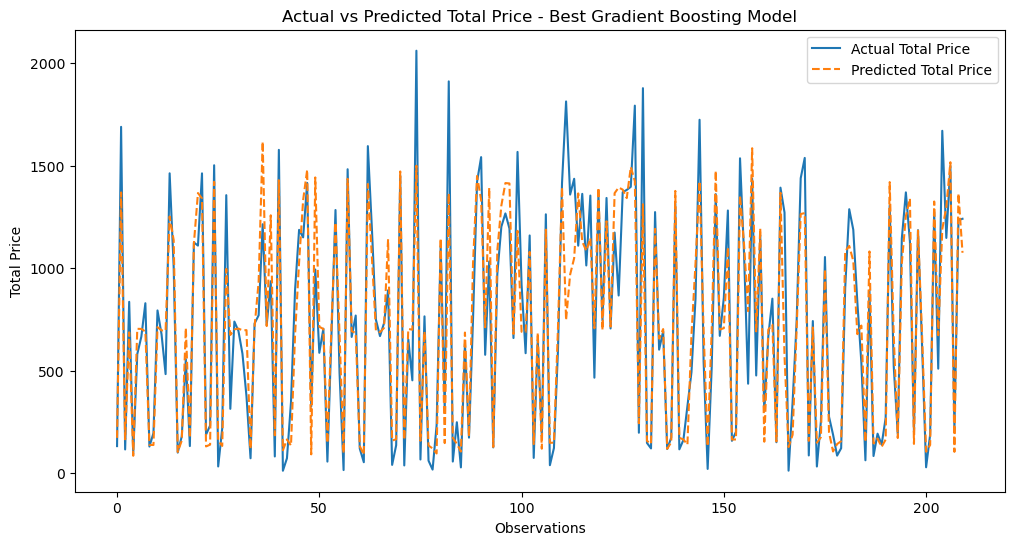

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}


gbr = GradientBoostingRegressor(random_state=42)


grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)


grid_search.fit(X_train, y_train)


print(f'Best parameters: {grid_search.best_params_}')


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


y_pred = [max(0, pred) for pred in y_pred]


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Model MAE: {mae}')
print(f'Best Model MSE: {mse}')
print(f'Best Model R^2: {r2}')


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Total Price')
plt.plot(y_pred, label='Predicted Total Price', linestyle='--')
plt.title('Actual vs Predicted Total Price - Best Gradient Boosting Model')
plt.xlabel('Observations')
plt.ylabel('Total Price')
plt.legend()
plt.show()


In [119]:
GB = pd.DataFrame({'Model' : ['Initial Gradient Boosting','Tuned Gradient Boosting'],
                'MSE' : [35964.605957, 36315.011167094286]}).set_index('Model')
GB

,MSE
Model,
Initial Gradient Boosting,35964.605957
Tuned Gradient Boosting,36315.011167


## Feature Importances



                 Feature  Importance
3     time_phase_Morning    0.695402
4       time_phase_Night    0.110781
2   time_phase_Afternoon    0.092899
17       Day_name_Friday    0.027218
19     Day_name_Saturday    0.021839
0           Day_of_month    0.016543
1                Weekend    0.015144
21     Day_name_Thursday    0.005136
15    Month_name_October    0.002533
7    Month_name_December    0.002266
14   Month_name_November    0.002254
20       Day_name_Sunday    0.001818
10       Month_name_July    0.001584
9     Month_name_January    0.000825
6      Month_name_August    0.000815
12      Month_name_March    0.000777
8    Month_name_February    0.000693
23    Day_name_Wednesday    0.000600
22      Day_name_Tuesday    0.000243
18       Day_name_Monday    0.000224
16  Month_name_September    0.000145
13        Month_name_May    0.000104
5       Month_name_April    0.000101
11       Month_name_June    0.000057


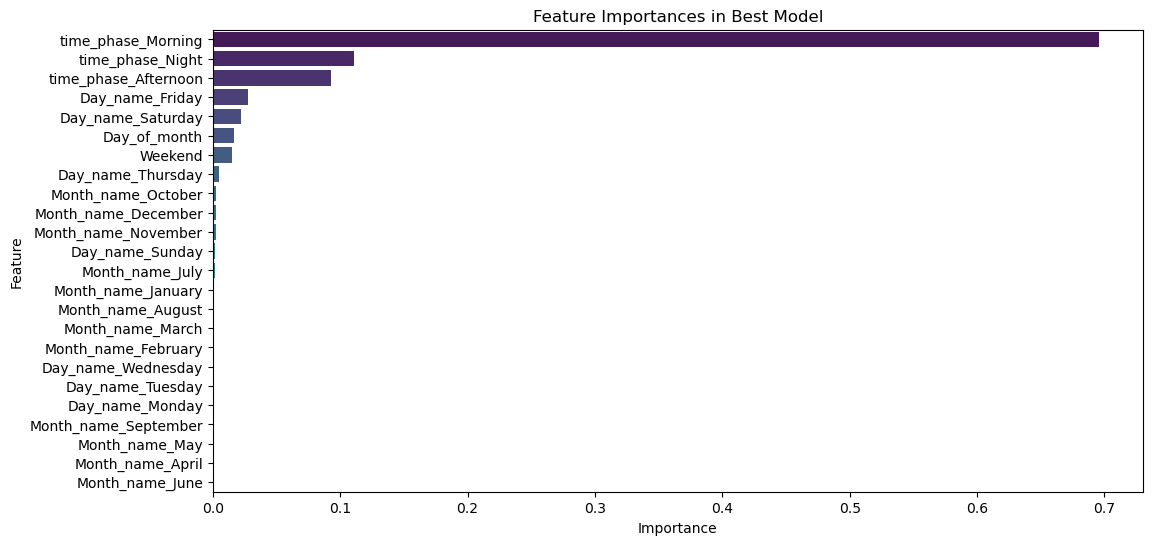

In [120]:
feature_importances = best_model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


print(features_df)


plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances in Best Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Model saving 

In [121]:
joblib.dump(best_model,'./best_model.pkl')

['./best_model.pkl']

## Simplified model
Use of the most important features

In [35]:
y = df['total_price']
X = df[['time_phase_Morning', 'time_phase_Night', 'time_phase_Afternoon', 'Day_name_Friday', 'Day_name_Saturday', 'Day_of_month', 'Weekend', 'Day_name_Thursday']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GrB = GradientBoostingRegressor(random_state=42)

GrB.fit(X_train, y_train)

y_pred = GrB.predict(X_test)

y_pred = [max(0, pred) for pred in y_pred]

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Simplified Model MAE: {mae}')
print(f'Simplified Model MSE: {mse}')
print(f'Simplified Model R^2: {r2}')

Simplified Model MAE: 135.3583237310263
Simplified Model MSE: 40019.16172320651
Simplified Model R^2: 0.8576281354692828


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}
Best Simplified Model MAE: 131.04853745145957
Best Simplified Model MSE: 36000.73747714783
Best Simplified Model R^2: 0.8719240509195822


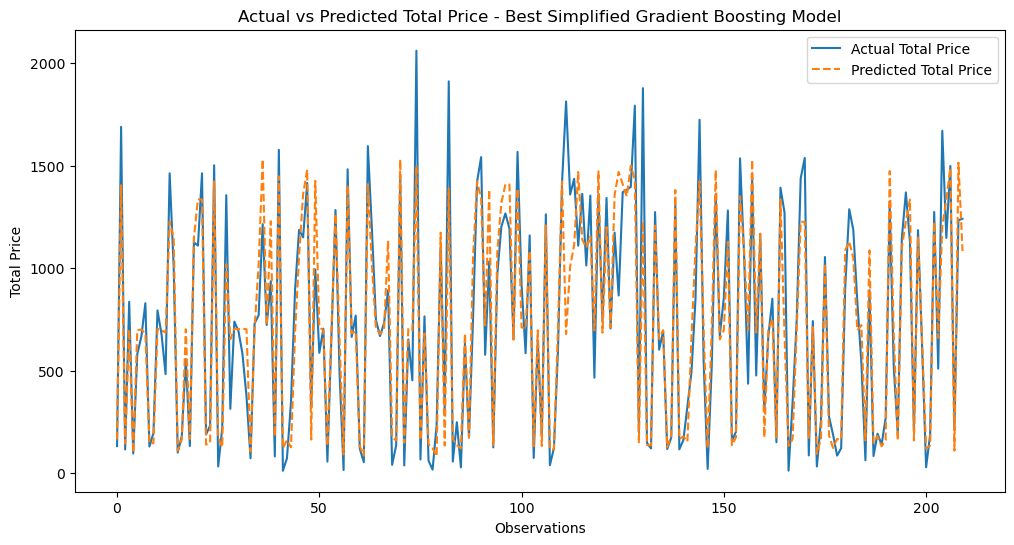

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0]
}


gbr2 = GradientBoostingRegressor(random_state=42)


grid_search2 = GridSearchCV(estimator=gbr2, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)


grid_search2.fit(X_train, y_train)


print(f'Best parameters: {grid_search2.best_params_}')


best_model2 = grid_search2.best_estimator_
y_pred = best_model2.predict(X_test)


y_pred = [max(0, pred) for pred in y_pred]


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Simplified Model MAE: {mae}')
print(f'Best Simplified Model MSE: {mse}')
print(f'Best Simplified Model R^2: {r2}')


plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Total Price')
plt.plot(y_pred, label='Predicted Total Price', linestyle='--')
plt.title('Actual vs Predicted Total Price - Best Simplified Gradient Boosting Model')
plt.xlabel('Observations')
plt.ylabel('Total Price')
plt.legend()
plt.show()

In [37]:
joblib.dump(best_model2,'./best_simplified_model.pkl')

['./best_simplified_model.pkl']

## Summary 

The analyzed dataset from Kaggle contained data on pizza sales throughout the year. It included information, among other things, about the time of purchase (morning, afternoon, night). Basic dataset information and descriptive statistics for numerical variables were checked. One feature that was irrelevant was removed. Renamed another feature to make it easier to understand. There were no missing values ​​or duplicates in the dataset.

Several visualizations were made, which show that the highest sales occurred in the afternoons and the lowest in the mornings. The monthly sales trend chart shows that the highest sales were in July and the lowest in September-October. When divided into days, the highest sales occurred from Thursday to Saturday. A box plot of sales in the analyzed time periods was also made.

Categorical features were coded using the one-hot method. The correlation between the features was examined and histograms were made.

To create the prediction model, 9 different models were compared, including Decision Tree, Random Forest and Support Vector Regressor. For each model, the results of the metrics: Mean Absolute Error, Mean Squared Error and R2 were examined. The Gradient Boosting model achieved the best results. For this model, hyperparameters were adjusted and the importance of features was calculated.

A simplified Gradient Boosting model with the most important features was also created and hyperparameters were adjusted.

Although the tuned full model shows slightly worse performance metrics compared to its initial evaluation, the use of cross-validation during hyperparameter tuning ensures that the model is more stable and less likely to overfit to the training data. This stability is critical for making reliable predictions on new, unseen data. In the case of the simplified model, hyperparameter tuning improved the performance metrics, highlighting the importance of this step in optimizing model performance.

The simplified model not only provides better performance metrics but also offers increased interpretability and reduced complexity. Therefore, it is recommended to use the simplified model as the primary model for predicting sales in this project.